In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from pprint import pprint
import random
import os

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
model_type = 'resnet'
input_shape = (32, 32, 3)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


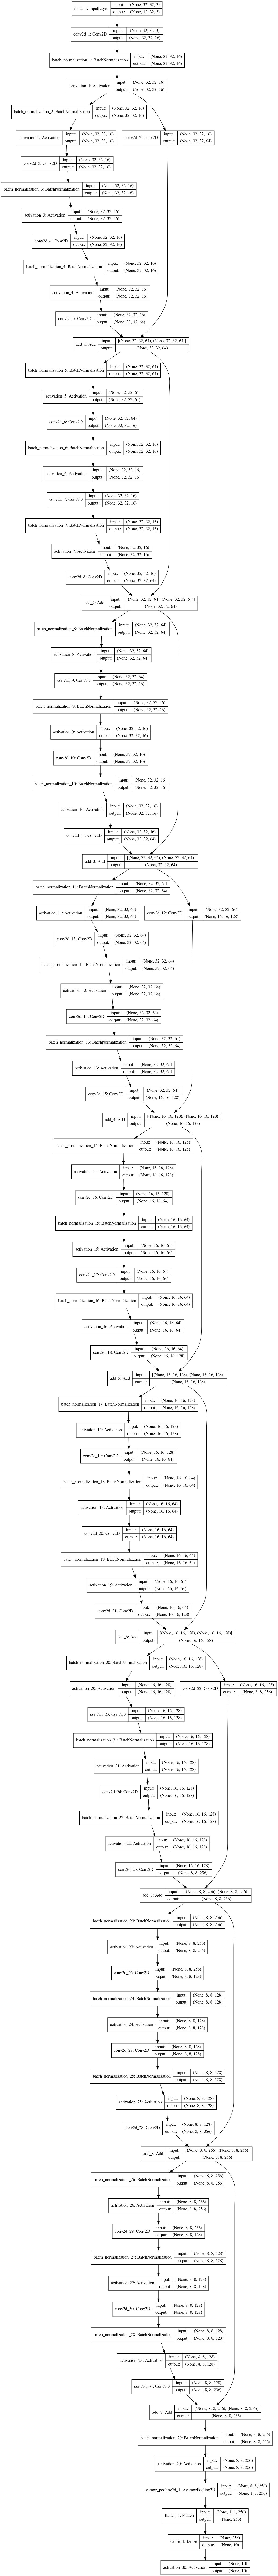

In [3]:
Input = keras.layers.Input
Conv2D = keras.layers.Conv2D
Activation = keras.layers.Activation
BatchNormalization = keras.layers.BatchNormalization
AveragePooling2D = keras.layers.AveragePooling2D
Flatten = keras.layers.Flatten
Dropout = keras.layers.Dropout
Dense = keras.layers.Dense

def block_bac(inputs, filters, activation='relu', kernel_size=1, strides=1, padding='same'):
    b = BatchNormalization()(inputs)
    a = Activation(activation)(b)
    c = Conv2D(filters, kernel_size, strides=strides, padding=padding)(a)
    return c

def block_res(inputs, small, large, firstlayer=False, firststride=2):
    if firstlayer:
        s = Conv2D(filters=large, kernel_size=1, padding='same', strides=firststride)(inputs)
    else:
        s = inputs
    c = block_bac(inputs, filters=small, kernel_size=1)
    c = block_bac(c, filters=small, kernel_size=3)
    if firstlayer:
        c = block_bac(c, filters=large, kernel_size=1, strides=firststride)
    else:
        c = block_bac(c, filters=large, kernel_size=1, strides=1)
    return keras.layers.add([c, s])
    

# Input block
i = Input(shape=input_shape)
c = Conv2D(filters=16, kernel_size=3, padding='same')(i)
b = BatchNormalization()(c)
a = Activation('relu')(b)

r = block_res(a, 16, 64, firstlayer=True, firststride=1)
r = block_res(r, 16, 64)
r = block_res(r, 16, 64)

r = block_res(r, 64, 128, firstlayer=True)
r = block_res(r, 64, 128)
r = block_res(r, 64, 128)

r = block_res(r, 128, 256, firstlayer=True)
r = block_res(r, 128, 256)
r = block_res(r, 128, 256)

b = BatchNormalization()(r)
a = Activation('relu')(b)
av = AveragePooling2D(8)(a)
f = Flatten()(av)
d = Dense(num_classes)(f)
ac = Activation('softmax')(d)

model = keras.Model(inputs=i, outputs=ac)

keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [4]:


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                               cooldown=0,
                                               patience=5,
                                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])




Learning rate:  0.001


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


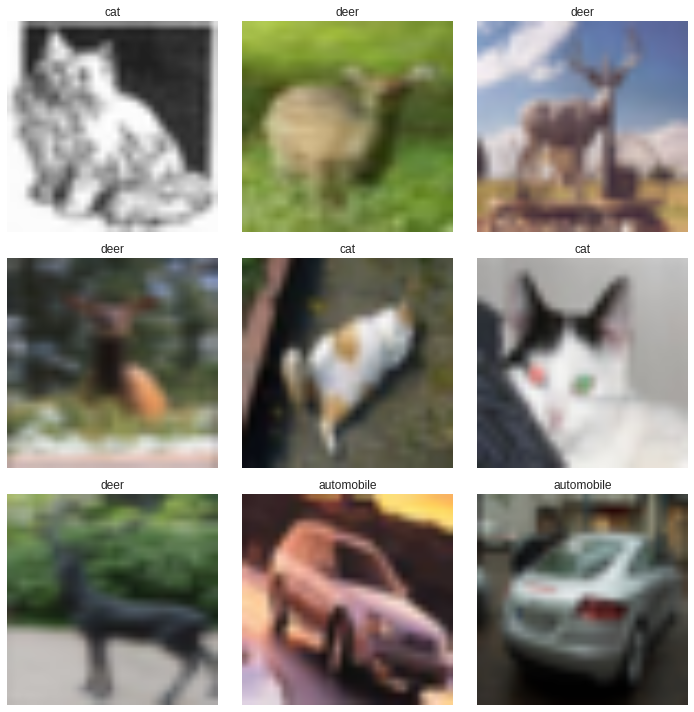

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    j = random.choice(range(len(X_train)))
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(X_train[j], interpolation='bilinear')
    ax.set_title('{}'.format(classes[y_train[j][0]]))
    ax.axis('off')
fig.tight_layout()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [6]:
# Input image dimensions.
input_shape = X_train.shape[1:]

# Normalize data.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Subtract pixel mean is enabled
X_train_mean = np.mean(X_train, axis=0)
X_train -= X_train_mean
X_test -= X_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(X_train)

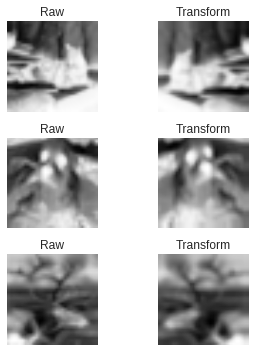

In [7]:
fig = plt.figure(figsize=(5, 5))
for i in range(3):
    ax1 = fig.add_subplot(3, 2, i*2+1)
    ax2 = fig.add_subplot(3, 2, i*2+2)
    
    j = random.choice(range(len(X_train)))
    x = X_train[j]
    y = datagen.random_transform(x)
    
    ax1.imshow(x[:, :, 0], interpolation='bilinear')
    ax1.set_title("Raw")
    ax1.axis('off')
    
    ax2.imshow(y[:, :, 0], interpolation='bilinear')
    ax2.set_title("Transform")
    ax2.axis('off')
fig.tight_layout()

In [8]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=40,
                    validation_data=(X_test, y_test),
                    workers=32,
                    callbacks=callbacks)

Epoch 1/40
Learning rate:  0.001
1563/1563 [==============================] - 128s 82ms/step - loss: 1.3602 - accuracy: 0.5060 - val_loss: 1.2805 - val_accuracy: 0.5641

Epoch 00001: loss improved from inf to 1.36004, saving model to /home/zcc/Documents/cifar10_resnet/saved_models/cifar10_resnet_model.001.h5
Epoch 2/40
Learning rate:  0.001
1563/1563 [==============================] - 111s 71ms/step - loss: 0.9811 - accuracy: 0.6522 - val_loss: 1.0068 - val_accuracy: 0.6487

Epoch 00002: loss improved from 1.36004 to 0.98103, saving model to /home/zcc/Documents/cifar10_resnet/saved_models/cifar10_resnet_model.002.h5
Epoch 3/40
Learning rate:  0.001
1563/1563 [==============================] - 111s 71ms/step - loss: 0.8155 - accuracy: 0.7130 - val_loss: 0.8501 - val_accuracy: 0.7163

Epoch 00003: loss improved from 0.98103 to 0.81552, saving model to /home/zcc/Documents/cifar10_resnet/saved_models/cifar10_resnet_model.003.h5
Epoch 4/40
Learning rate:  0.001
1563/1563 [==================

In [9]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 514us/step
Test loss: 0.3720838087975979
Test accuracy: 0.8902000188827515
